In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
import numpy as np

Using TensorFlow backend.
C:\Users\cooke\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cooke\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cooke\.conda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cooke\.conda\envs\tf\lib\site-packages\tensorflow\python

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# load dataset
dataset = read_csv('D:/Data/stock/denque1.csv', header=0, index_col=0)
values = dataset.values
dataset.info()
print(dataset.isnull().sum())
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 1
n_features = 9
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 261 entries, 2010/1/2 00:00 to 2010/1/12 20:00
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   denque              261 non-null    int64  
 1   MeanHumidity        261 non-null    float64
 2   Precipitations      261 non-null    int64  
 3   MeanPrecipitations  261 non-null    float64
 4   MeanSunshine        261 non-null    float64
 5   HighestTemperature  261 non-null    float64
 6   LowestTemperature   261 non-null    float64
 7   MeanTemperature     261 non-null    float64
 8   NumberOfSearches    261 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 20.4+ KB
denque                0
MeanHumidity          0
Precipitations        0
MeanPrecipitations    0
MeanSunshine          0
HighestTemperature    0
LowestTemperature     0
MeanTemperature       0
NumberOfSearches      0
dtype: int64
(260, 18)


In [5]:
# split into train and test sets
values = reframed.values
rumtime=10
score=[[0]*4 for i in range(rumtime)]

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

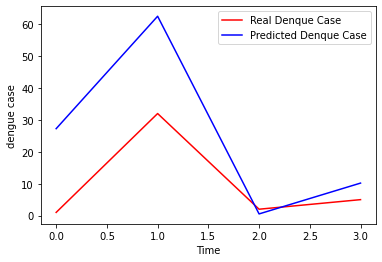

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

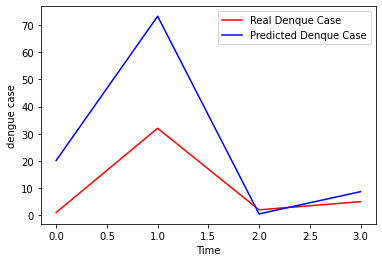

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

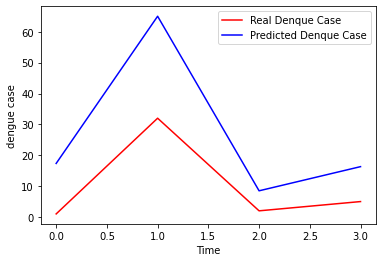

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

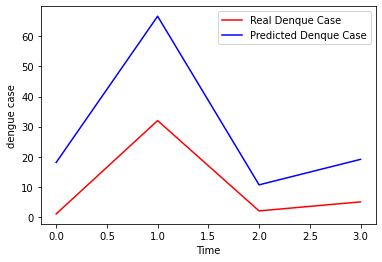

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

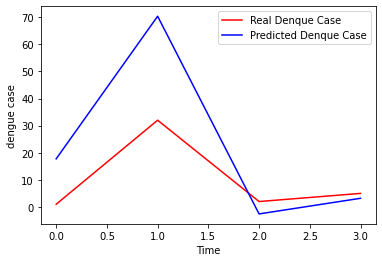

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

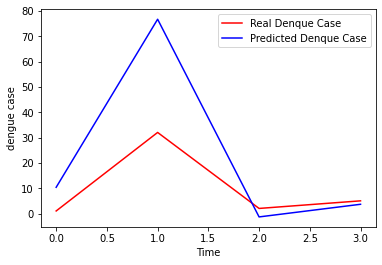

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

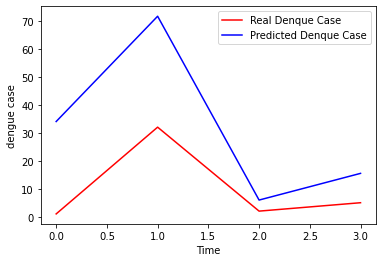

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

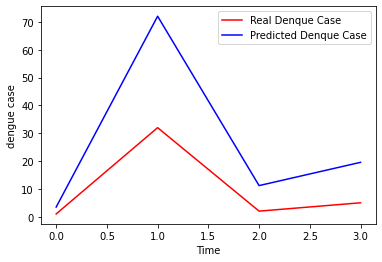

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

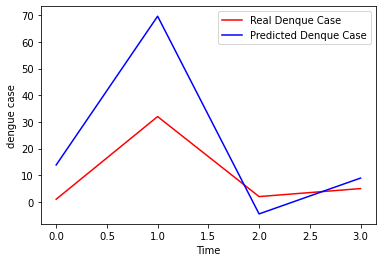

[[3.8925651e-04 5.3103614e-01 5.2287583e-03 ... 6.8202770e-01
  7.8022289e-01 2.6999998e-01]
 [0.0000000e+00 1.8172097e-01 0.0000000e+00 ... 6.1751151e-01
  6.6476560e-01 1.7999999e-01]
 [0.0000000e+00 4.2572784e-01 0.0000000e+00 ... 4.7004607e-01
  3.3966637e-01 0.0000000e+00]
 ...
 [3.8925651e-04 7.8467488e-01 9.2810459e-02 ... 3.8709679e-01
  4.3990147e-01 0.0000000e+00]
 [3.2347217e-01 6.0338187e-01 0.0000000e+00 ... 3.6866364e-01
  4.0814674e-01 0.0000000e+00]
 [0.0000000e+00 6.6759419e-01 6.0130719e-02 ... 5.8986175e-01
  5.9728706e-01 2.6999998e-01]]
[[3.89256515e-04 9.27654266e-01 7.33333349e-01 7.33333409e-01
  4.62962966e-03 6.18055463e-01 8.01843286e-01 7.45809197e-01
  9.99999940e-02 3.89256515e-04 6.53681517e-01 1.17647061e-02
  1.17647061e-02 8.61111104e-01 7.36111045e-01 8.94009233e-01
  8.85197997e-01 2.89999992e-01]
 [3.69793698e-02 8.00299883e-01 5.75163402e-02 5.75163402e-02
  2.31481478e-01 3.33333254e-01 4.42396373e-01 3.81594777e-01
  0.00000000e+00 1.24562085e-02

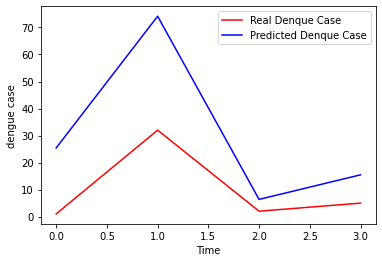

In [6]:
for i in range(rumtime): 
    train, test = train_test_split(values, random_state=0, train_size=0.985)
    print(train)
    print(test)
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    # 回復Training資料值為原始數據的規模
    trainPredict = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    trainPredict = concatenate((trainPredict, train_X[:,  -(n_features-1):]), axis=1)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainPredict = trainPredict[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    train_y = concatenate((train_y, train_X[:,  -(n_features-1):]), axis=1)
    train_y = scaler.inverse_transform(train_y)
    train_y = train_y[:,0]
    
    # 回復Testing資料值為原始數據的規模
    testPredict = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    testPredict = concatenate((testPredict, test_X[:, -(n_features-1):]), axis=1)
    testPredict = scaler.inverse_transform(testPredict)
    testPredict = testPredict[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    test_y = concatenate((test_y, test_X[:,  -(n_features-1):]), axis=1)
    test_y = scaler.inverse_transform(test_y)
    test_y = test_y[:,0]

    # calculate RMSE
    
    #calculate 均方根誤差(root mean squared error)
    trainScore = sqrt(mean_squared_error(train_y, trainPredict))
    print('Train RMSE: %.4f' % (trainScore))
    
    testScore = sqrt(mean_squared_error(test_y, testPredict))
    print('Test RMSE: %.4f' % (testScore))
    n = len(test_y)
    mape = sum(np.abs((test_y - testPredict)/test_y))/n*100
    print('Test MAPE: %.4f' % (mape))
    pyplot.plot(test_y, color =  'red', label = 'Real Denque Case')  # 紅線表示真實登革熱數
    pyplot.plot(testPredict, color = 'blue', label = 'Predicted Denque Case')  # 藍線表示預測登革熱數
    pyplot.xlabel('Time')
    pyplot.ylabel('dengue case')
    pyplot.legend()
    pyplot.show()
    
    score[i][0]=trainScore
    score[i][1]=testScore
    score[i][2]=trainPredict.tolist()
    score[i][3]=testPredict.tolist()